In [186]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import branca.colormap as cm

Initial EDA, we are trying to explore the NOx production through out the city

The Areas list the specific locations we are interested in and we wish to merge the location data to get the GPS coords of each area

In [491]:
df = pd.read_csv('./boston_corrected.csv')
df['TOWN']= df['TOWN'].apply(lambda x: x.replace('Boston ','')) #Remove Boston from front of name, this will be useful when merging locaiton dataset
print(df.head())
print(df.shape)
print(df.columns)
print(df.TOWN.unique())

         TOWN  TOWNNO  TRACT     LON      LAT  MEDV  CMEDV     CRIM    ZN  \
0      Nahant       0   2011 -70.955  42.2550  24.0   24.0  0.00632  18.0   
1  Swampscott       1   2021 -70.950  42.2875  21.6   21.6  0.02731   0.0   
2  Swampscott       1   2022 -70.936  42.2830  34.7   34.7  0.02729   0.0   
3  Marblehead       2   2031 -70.928  42.2930  33.4   33.4  0.03237   0.0   
4  Marblehead       2   2032 -70.922  42.2980  36.2   36.2  0.06905   0.0   

   INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO       B  LSTAT  
0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3  396.90   4.98  
1   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8  396.90   9.14  
2   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8  392.83   4.03  
3   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7  394.63   2.94  
4   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7  396.90   5.33  
(506, 20)
Index(['TOWN', 'TOWNNO', 'TRACT', 'LON', 'LAT', 'MEDV

In [492]:
uslocations = pd.read_csv('./US.txt',delimiter = '\t',header =None)
uslocations  = uslocations[uslocations.iloc[:,3] == 'Massachusetts']
uslocations = uslocations.rename(columns = {2:'TOWN',9:'Lat',10:'Lon'})
# uslocations[uslocations.duplicated(subset=['TOWN'],keep=False)]
uslocations = uslocations[['TOWN','Lat','Lon']]
print(uslocations.shape)
uslocations = uslocations.drop_duplicates(['TOWN'])
print(uslocations.shape)
print(uslocations.TOWN.nunique())

df = df.set_index('TOWN').join(uslocations.set_index('TOWN'), how = 'left').reset_index()

(684, 3)
(510, 3)
510


Check which towns weren't located and manually impute data

In [493]:
df[df.Lat.isnull()]['TOWN'].unique()

array(['Allston-Brighton', 'Back Bay', 'Beacon Hill', 'Downtown',
       'East Boston', 'Forest Hills', 'North End', 'Sargus', 'Savin Hill',
       'South Boston'], dtype=object)

In [496]:
ManualImputation = {'Allston-Brighton':[42.3539,-71.1337],'Back Bay': [42.3503, -71.0810], 'Beacon Hill': [42.3588, -71.0707], 'Downtown': [42.3557, -71.0572], 'East Boston': [42.3702, -71.0389], 'Forest Hills':[40.7181, -73.8448], 'North End':[42.3647, -71.0542], 'Sargus':[42.4651, -71.0110], 'Savin Hill':[42.3099, -71.0500], 'South Boston':[42.3381, -71.0476]}

In [495]:
df.loc[df['TOWN']=='Back Bay', 'Lon']

17   NaN
18   NaN
19   NaN
20   NaN
21   NaN
22   NaN
Name: Lon, dtype: float64

In [497]:
for key in ManualImputation:
    for town in df.TOWN.unique():
        if key == town:
            print(town)
            df.loc[df['TOWN']==town, 'Lat']= ManualImputation[key][0]
            df.loc[df['TOWN']==town, 'Lon']= ManualImputation[key][1]

Allston-Brighton
Back Bay
Beacon Hill
Downtown
East Boston
Forest Hills
North End
Sargus
Savin Hill
South Boston


In [499]:
df[df.Lat.isnull()]['TOWN'].unique()

array([], dtype=object)

No missing values, all the towns are described! Let us now plot all of the locaitons

In [518]:
def VisualPlot(metric):
    minval = df[metric].min()
    maxval = df[metric].max()
    colormap = cm.LinearColormap(colors=['blue','red'],index = [minval,maxval],vmin = minval,vmax=maxval)
    lat = list(df.Lat)
    lon = list(df.Lon)
    Metr = list(df[metric])

    m = folium.Map([42.2,-71.1],zoom_start=10)

    for loc, p in zip(zip(lat, lon), Metr):
        folium.Circle(radius = 100,location = loc,fill =True, color = colormap(p),crs = 'EPSG4326').add_to(m)
    m.add_child(colormap)
    display(m)

VisualPlot('DIS')


In [501]:
df = df.rename({'NOX':'TargetNox'})


,TOWNNO,TRACT,LON,LAT,MEDV,CMEDV,CRIM,ZN,INDUS,CHAS,...,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Lat,Lon
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,...,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,47.531621,2700.357708,-71.056389,42.216440,22.532806,22.528854,3.613524,11.363636,11.136779,0.069170,...,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,42.338416,-71.130672
std,27.571401,1380.038110,0.075405,0.061777,9.197104,9.182176,8.601545,23.322453,6.860353,0.253994,...,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,0.218257,0.345279
min,0.000000,1.000000,-71.289500,42.030000,5.000000,5.000000,0.006320,0.000000,0.460000,0.000000,...,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,40.718100,-73.844800
25%,26.250000,1303.250000,-71.093225,42.180775,17.025000,17.025000,0.082045,0.000000,5.190000,0.000000,...,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,42.297300,-71.158900
50%,42.000000,3393.500000,-71.052900,42.218100,21.200000,21.200000,0.256510,0.000000,9.690000,0.000000,...,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,42.364700,-71.095300
75%,78.000000,3739.750000,-71.019625,42.252250,25.000000,25.000000,3.677083,12.500000,18.100000,0.000000,...,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,42.420200,-71.033900
max,91.000000,5082.000000,-70.810000,42.381000,50.000000,50.000000,88.976200,100.000000,27.740000,1.000000,...,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,42.641500,-70.699300


<AxesSubplot:>

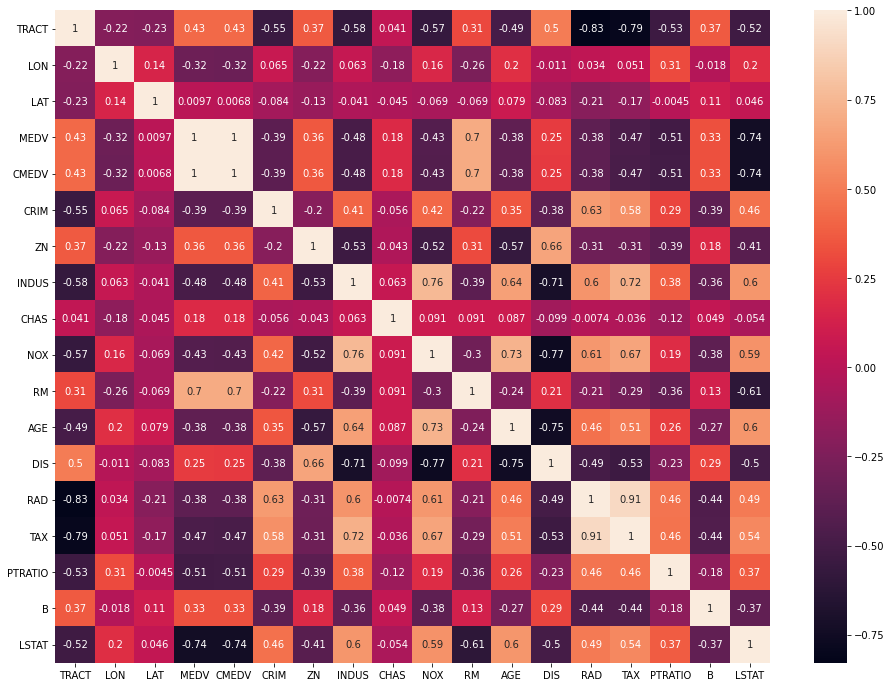

In [178]:
fig,ax =plt.subplots(figsize = (16,12))
sns.heatmap(df.corr(),ax=ax,annot=True)

In [175]:
predictors = ['CRIM','CMEDV','ZN','INDUS','CHAS','RM','AGE','TAX','B','LSTAT','DIS','RAD','NOX','PTRATIO']


Lets first look at the geographical distribution of the data, boston is a city in the US, it would be good to look at how the areas are distributed

In [24]:
df.groupby('TOWN').count()['LAT'].sort_values(ascending =False)

TOWN
Cambridge            30
Boston Savin Hill    23
Lynn                 22
Boston Roxbury       19
Newton               18
                     ..
Norwell               1
Dover                 1
Hamilton              1
Sherborn              1
Cohasset              1
Name: LAT, Length: 92, dtype: int64

There are clearly issues with the sptial coordinate data :(. Perhaps we can use the names of the areas to plot geospatial distribution


In [517]:
df['Allston']

KeyError: 'Allston'